<a href="https://colab.research.google.com/github/0e-gn-128/0e-gn-128/blob/main/openpose.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Pose Detection with OpenPose

This notebook uses an open source project [CMU-Perceptual-Computing-Lab/openpose](https://github.com/CMU-Perceptual-Computing-Lab/openpose.git) to detect/track multi person poses on a given video.

Please read the [OpenPose license](https://github.com/CMU-Perceptual-Computing-Lab/openpose/blob/master/LICENSE) before running this script.


In [37]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [38]:
import os
OPENPOSE_PATH="./openpose/"
HOME_PATH='./'

In [39]:
!echo $HOME_PATH

./


##OpenPoseのインストール

In [40]:
#@title
!pip install ffmpeg-python
from os.path import exists, join, basename, splitext

def show_local_mp4_video(file_name, width=640, height=480):
  import io
  import base64
  from IPython.display import HTML
  video_encoded = base64.b64encode(io.open(file_name, 'rb').read())
  return HTML(data='''<video width="{0}" height="{1}" alt="test" controls>
                        <source src="data:video/mp4;base64,{2}" type="video/mp4" />
                      </video>'''.format(width, height, video_encoded.decode('ascii')))


# see: https://github.com/CMU-Perceptual-Computing-Lab/openpose/issues/949
# install new CMake becaue of CUDA10
!wget -q https://cmake.org/files/v3.17/cmake-3.17.2-Linux-x86_64.tar.gz
!tar xfz cmake-3.17.2-Linux-x86_64.tar.gz --strip-components=1 -C /usr/local

# install system dependencies
!apt-get -qq install -y libatlas-base-dev libprotobuf-dev libleveldb-dev libsnappy-dev libhdf5-serial-dev protobuf-compiler libgflags-dev libgoogle-glog-dev liblmdb-dev opencl-headers ocl-icd-opencl-dev libviennacl-dev

git_repo_url = 'https://github.com/CMU-Perceptual-Computing-Lab/openpose.git'
project_name = splitext(basename(git_repo_url))[0]
!rm -rf openpose
# clone openpose
!git clone -q --depth 1 $git_repo_url
# --recursive necessary in the line below, as otherwise you can (sometimes) get "lpthreads" errors in cmake ("undefined reference to `pthread_create'" etc). See, for example, https://github.com/facebookarchive/caffe2/issues/1234
!sed -i 's/execute_process(COMMAND git checkout --recursive master WORKING_DIRECTORY ${CMAKE_SOURCE_DIR}\/3rdparty\/caffe)/execute_process(COMMAND git checkout f019d0dfe86f49d1140961f8c7dec22130c83154 WORKING_DIRECTORY ${CMAKE_SOURCE_DIR}\/3rdparty\/caffe)/g' openpose/CMakeLists.txt
!cd openpose && git submodule update --init --recursive --remote

ERROR: Operation cancelled by user
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/pip/_internal/cli/base_command.py", line 179, in exc_logging_wrapper
    status = run_func(*args)
             ^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/pip/_internal/cli/req_command.py", line 67, in wrapper
    return func(self, options, args)
           ^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/pip/_internal/commands/install.py", line 447, in run
    conflicts = self._determine_conflicts(to_install)
                ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/pip/_internal/commands/install.py", line 578, in _determine_conflicts
    return check_install_conflicts(to_install)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/pip/_internal/operations/check.py", line 101, in check_install_conflicts
    package_set, _ = create_package_

Workaround for server problem (run if you see `file DOWNLOAD HASH mismatch` when building OpenPose):

# OpenPoseのモデル（archive.zip）の解凍

In [16]:
!unzip archive.zip

Archive:  archive.zip
  inflating: pose_iter_102000.caffemodel  
  inflating: pose_iter_116000.caffemodel  
  inflating: pose_iter_160000.caffemodel  
  inflating: pose_iter_440000.caffemodel  
  inflating: pose_iter_584000.caffemodel  


In [15]:
#@title
# Workaround for server connection problem ("file DOWNLOAD HASH mismatch"),see, e.g.,
# https://github.com/CMU-Perceptual-Computing-Lab/openpose/issues/1602#issuecomment-641653411
#!apt-get install unzip

# !wget -O models.zip  --no-check-certificate -r 'https://drive.google.com/uc?id=1QCSxJZpnWvM00hx49CJ2zky7PWGzpcEh&export=download'
#!unzip -o models.zip -d openpose

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
unzip is already the newest version (6.0-26ubuntu3.2).
0 upgraded, 0 newly installed, 0 to remove and 19 not upgraded.
unzip:  cannot find or open models.zip, models.zip.zip or models.zip.ZIP.


In [17]:
# use 'sed' to comment out the line in the OpenPose repo that downloads the model from the failed link
! sed -i 's/executeShInItsFolder "getModels.sh"/# executeShInItsFolder "getModels.sh"/g' ./openpose/scripts/ubuntu/install_openpose_JetsonTX2_JetPack3.1.sh
! sed -i 's/executeShInItsFolder "getModels.sh"/# executeShInItsFolder "getModels.sh"/g' ./openpose/scripts/ubuntu/install_openpose_JetsonTX2_JetPack3.3.sh
! sed -i 's/download_model("BODY_25"/# download_model("BODY_25"/g' ./openpose/CMakeLists.txt
! sed -i 's/78287B57CF85FA89C03F1393D368E5B7/# 78287B57CF85FA89C03F1393D368E5B7/g' ./openpose/CMakeLists.txt
! sed -i 's/download_model("body (COCO)"/# download_model("body (COCO)"/g' ./openpose/CMakeLists.txt
! sed -i 's/5156d31f670511fce9b4e28b403f2939/# 5156d31f670511fce9b4e28b403f2939/g' ./openpose/CMakeLists.txt
! sed -i 's/download_model("body (MPI)"/# download_model("body (MPI)"/g' ./openpose/CMakeLists.txt
! sed -i 's/2ca0990c7562bd7ae03f3f54afa96e00/# 2ca0990c7562bd7ae03f3f54afa96e00/g' ./openpose/CMakeLists.txt
! sed -i 's/download_model("face"/# download_model("face"/g' ./openpose/CMakeLists.txt
! sed -i 's/e747180d728fa4e4418c465828384333/# e747180d728fa4e4418c465828384333/g' ./openpose/CMakeLists.txt
! sed -i 's/download_model("hand"/# download_model("hand"/g' ./openpose/CMakeLists.txt
! sed -i 's/a82cfc3fea7c62f159e11bd3674c1531/# a82cfc3fea7c62f159e11bd3674c1531/g' ./openpose/CMakeLists.txt

In [18]:
! ls -lha /usr/lib/x86_64-linux-gnu

total 4.3G
drwxr-xr-x  1 root root  4.0K Feb  6 18:06 .
drwxr-xr-x  1 root root  4.0K Feb  5 14:17 ..
drwxr-xr-x  2 root root  4.0K Feb  5 14:16 atlas
drwxr-xr-x  2 root root  4.0K Jun 27  2024 audit
drwxr-xr-x  2 root root  4.0K Feb  5 14:16 avahi
drwxr-xr-x  2 root root  4.0K Jul 10  2024 bfd-plugins
drwxr-xr-x  2 root root  4.0K Feb  5 14:16 blas
drwxr-xr-x  2 root root  4.0K Feb  5 14:16 caca
drwxr-xr-x  3 root root  4.0K Feb  5 14:16 ceph
drwxr-xr-x  1 root root  4.0K Feb  6 18:06 cmake
-rw-r--r--  1 root root  1.8K May  6  2024 crt1.o
-rw-r--r--  1 root root  1.2K May  6  2024 crti.o
-rw-r--r--  1 root root   760 May  6  2024 crtn.o
drwxr-xr-x  2 root root  4.0K Feb  5 14:16 dri
drwxr-xr-x  2 root root  4.0K Jun 27  2024 e2fsprogs
drwxr-xr-x  1 root root  4.0K Feb  5 14:16 engines-3
drwxr-xr-x  4 root root  4.0K Feb  5 14:16 fortran
drwxr-xr-x  3 root root   12K Jun 27  2024 gconv
-rw-r--r--  1 root root  2.5K May  6  2024 gcrt1.o
drwxr-xr-x  2 root root  4.0K Feb  5 14:16 gdalpl

In [19]:
# build openpose
# CUDA
# !cd openpose && rm -rf build || true && mkdir build && cd build && cmake .. -DUSE_CUDNN=OFF && make -j`nproc`
#!cd openpose && rm -rf build || true && mkdir build && cd build && cmake .. && make -j`nproc`
# CPU
# !cd openpose && rm -rf build || true && mkdir build && cd build && cmake -DGPU_MODE=CPU_ONLY -DUSE_MKL=OFF .. && cmake --build . --config Release && make -j`nproc`

!cd openpose && rm -rf build || true && mkdir build

In [20]:
cmake_file='/content/openpose/CMakeLists.txt'
!cd openpose && sed -i 's/-DBUILD_python=OFF/-DBUILD_python=ON/g' $cmake_file
!cd openpose && sed -i 's/-DBUILD_python_layer=OFF/-DBUILD_python_layer=ON/g' $cmake_file

!cd openpose && sed -i 's/option(BUILD_PYTHON "Build OpenPose python." OFF)/option(BUILD_PYTHON "OpenPose python." ON)\noption(BUILD_BIN_FOLDER "Copy 3rd-party DLL files." ON)/g' $cmake_file

In [21]:
# CUDA
!cd openpose && cd build && cmake .. -DUSE_CUDNN=OFF -DGENERATE_PYTHON_BINDINGS:BOOL="1" -DPYTHON_LIBRARY='/usr/lib/x86_64-linux-gnu/libpython3.10.so' && make -j`nproc`

 # CPU
# !cd openpose && cd build && cmake .. -DGPU_MODE=CPU_ONLY -DUSE_MKL=OFF -DGENERATE_PYTHON_BINDINGS:BOOL="1" -DPYTHON_LIBRARY='/usr/lib/x86_64-linux-gnu/libpython3.10.so'
# !cd openpose && cd build && make -j`nproc`

-- The C compiler identification is GNU 11.4.0
-- The CXX compiler identification is GNU 11.4.0
-- Check for working C compiler: /usr/bin/cc
-- Check for working C compiler: /usr/bin/cc - works
-- Detecting C compiler ABI info
-- Detecting C compiler ABI info - done
-- Detecting C compile features
-- Detecting C compile features - done
-- Check for working CXX compiler: /usr/bin/c++
-- Check for working CXX compiler: /usr/bin/c++ - works
-- Detecting CXX compiler ABI info
-- Detecting CXX compiler ABI info - done
-- Detecting CXX compile features
-- Detecting CXX compile features - done
-- GCC detected, adding compile flags
-- GCC detected, adding compile flags
-- Looking for pthread.h
-- Looking for pthread.h - found
-- Performing Test CMAKE_HAVE_LIBC_PTHREAD
-- Performing Test CMAKE_HAVE_LIBC_PTHREAD - Success
-- Found Threads: TRUE  
-- Found CUDA: /usr/local/cuda (found version "12.5") 
-- Building with CUDA.
-- CUDA detected: 12.5
-- Added CUDA NVCC flags for: sm_75
-- Found cuDNN

## Try on YouTube video

# 解析したい動画の指定

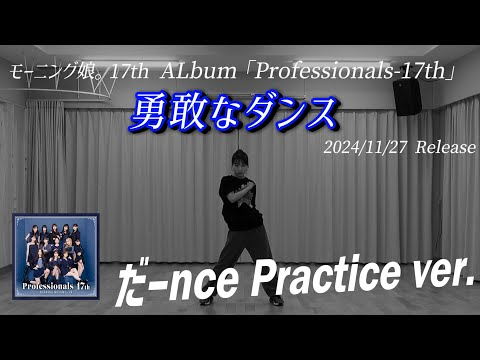

In [22]:
from IPython.display import YouTubeVideo
YOUTUBE_ID = "GHikUbm58pY"
YouTubeVideo(YOUTUBE_ID)

Download the above youtube video, cut and do the pose detection on that section:

In [23]:
# ! sudo -H pip install --upgrade youtube-dl
! pip install --upgrade --force-reinstall "git+https://github.com/ytdl-org/youtube-dl.git"

  Cloning https://github.com/ytdl-org/youtube-dl.git to /tmp/pip-req-build-e0bwgmy0
  Running command git clone --filter=blob:none --quiet https://github.com/ytdl-org/youtube-dl.git /tmp/pip-req-build-e0bwgmy0
  Resolved https://github.com/ytdl-org/youtube-dl.git to commit 5975d7bb96095fae7c35e7cfcd819255a5b57087
  Preparing metadata (setup.py) ... done
  Created wheel for youtube_dl: filename=youtube_dl-2021.12.17-py2.py3-none-any.whl size=1973838 sha256=9b9c5f0bf7be1809346d822292ae2f830d09df894694fa0fb32b4f94fdcf7e79
  Stored in directory: /tmp/pip-ephem-wheel-cache-4rutwv_3/wheels/91/cb/b5/629bb9aeb351f550a453ee0e4cccdea4c8cf4a16074cb0bd4e
Successfully built youtube_dl


In [43]:
#!rm -rf youtube.mp4
# download the youtube with the given ID
#!youtube-dl -f 'bestvideo[ext=mp4]' --output "youtube.%(ext)s" https://www.youtube.com/watch?v=$YOUTUBE_ID
# cut the video
#!ffmpeg -y -loglevel info -i youtube.mp4 -ss 160 -t 20 video.mp4

# 動画解析

In [44]:
# detect poses on the these 5 seconds
!cd $OPENPOSE_PATH && rm ./openpose.avi
!cd $OPENPOSE_PATH && chmod -R 755 './build/'
!cd $OPENPOSE_PATH && ./build/examples/openpose/openpose.bin --video ../video.mp4 --write_json ./output/ --display 0  --write_video ../openpose.avi --face
# convert the result into MP4
!ffmpeg -y -loglevel info -i openpose.avi output.mp4

rm: cannot remove './openpose.avi': No such file or directory
chmod: cannot access './build/': No such file or directory
/bin/bash: line 1: ./build/examples/openpose/openpose.bin: No such file or directory
ffmpeg version 4.4.2-0ubuntu0.22.04.1 Copyright (c) 2000-2021 the FFmpeg developers
  built with gcc 11 (Ubuntu 11.2.0-19ubuntu1)
  configuration: --prefix=/usr --extra-version=0ubuntu0.22.04.1 --toolchain=hardened --libdir=/usr/lib/x86_64-linux-gnu --incdir=/usr/include/x86_64-linux-gnu --arch=amd64 --enable-gpl --disable-stripping --enable-gnutls --enable-ladspa --enable-libaom --enable-libass --enable-libbluray --enable-libbs2b --enable-libcaca --enable-libcdio --enable-libcodec2 --enable-libdav1d --enable-libflite --enable-libfontconfig --enable-libfreetype --enable-libfribidi --enable-libgme --enable-libgsm --enable-libjack --enable-libmp3lame --enable-libmysofa --enable-libopenjpeg --enable-libopenmpt --enable-libopus --enable-libpulse --enable-librabbitmq --enable-librubberban


Finally, visualize the result:

# 解析した動画の確認

In [33]:
def show_local_mp4_video(file_name, width=640, height=480):
  import io
  import base64
  from IPython.display import HTML
  video_encoded = base64.b64encode(io.open(file_name, 'rb').read())
  return HTML(data='''<video width="{0}" height="{1}" alt="test" controls>
                        <source src="data:video/mp4;base64,{2}" type="video/mp4" />
                      </video>'''.format(width, height, video_encoded.decode('ascii')))

show_local_mp4_video('output.mp4', width=960, height=720)

FileNotFoundError: [Errno 2] No such file or directory: 'output.mp4'

## 解析結果のkeypointsの圧縮，ダウンロード

In [ ]:
# ダウンロードしたいフォルダを zip 圧縮する
!zip -r /content/keypoints.zip /content/openpose/output

In [ ]:
# 圧縮した zip ファイルをダウンロードする
from google.colab import files
files.download("/content/keypoints.zip")